
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.


# Projet final : Débordement d'égouts
### Équipe 17 : Elie Rouphael, Souhaila Mellouk, Thien-Kim Luu, Mourad Younes, Lynn Chararbsissy 
Remis le vendredi 20 décembre



# Table des matières


-  [1. Introduction](#1.-Introduction)


-  [2. Chargement des données et nettoyage préliminaire](#2.-Chargement-des-données-et-nettoyage-préliminaire)
    - [2.1. Chargement des surverses](#2.1.-Chargement-des-surverses)
    - [2.2. Nettoyage des données sur les surverses](#2.2.-Nettoyage-des-données-sur-les-surverses)
    - [2.3. Chargement des précipitations](#2.3.-Chargement-des-précipitations)
    - [2.4. Nettoyage des données sur les précipitations](#2.4.-Nettoyage-des-données-sur-les-précipitations)
    
    
- [3. Analyse exploratoire selon la classification bayésienne naïve](#3.-Analyse-exploratoire-selon-la-classification-bayésienne-naïve)
    - [3.1. Distances entre les stations et les ouvrages](#3.1.-Distances-entre-les-stations-et-les-ouvrages)
    - [3.2. Traitement des variables explicatives](#3.2.-Traitement-des-variables-explicatives)
    - [3.3. Prédictions pour l'année 2019](#3.3.-Prédictions-pour-l'année-2019)
     
     
-  [4. Idée rejetée](#4.-Idée-rejetée)


-  [5. Améliorations possibles](#5.-Améliorations-possibles)


-  [6. Conclusion](#6.-Conclusion)




## 1. Introduction

Le but de ce projet consiste à déterminer les caractéristiques des événements pluvieux susceptibles de générer des surverses sur le territoire de la Ville de Montréal. Il s'agit d'établir le lien entre les événements pluvieux et les surverses dues aux précipitations. On suppose que lorsqu'il n'y a pas de raison pour la surverse, il s'agit d'une surverse causée par les précipitations. Puisque nous nous intéresserons uniquement aux surverses occasionnées par les précipitations liquides, nous ne considérons que les mois de mai à octobre inclusivement.

Pour répondre à cette problématique, on propose dans ce qui suit une solution permettant de prédire les surverses pour la période à l'étude.

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/a238b752c33a41d9803c2cdde6bfc929

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Missings, Distributions

# 2. Chargement des données et nettoyage préliminaire

## 2.1. Chargement des surverses

In [2]:
data = CSV.read("data/surverses.csv",missingstring="-99999")
first(data,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON  │
│     │ String     │ Date       │ Int64⍰   │ String⍰ │
├─────┼────────────┼────────────┼──────────┼─────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ missing │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ missing │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ missing │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ missing │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ missing │

## 2.2. Nettoyage des données sur les surverses

#### Extraction des surverses pour les mois de mai à octobre inclusivement

In [3]:
data = filter(row -> month(row.DATE) > 4, data) 
data = filter(row -> month(row.DATE) < 11, data) 
first(data,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON  │
│     │ String     │ Date       │ Int64⍰   │ String⍰ │
├─────┼────────────┼────────────┼──────────┼─────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ missing │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ missing │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ missing │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ missing │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ missing │

#### Remplacement des valeurs *missing* dans la colonne :RAISON par "Inconnue"

In [4]:
raison = coalesce.(data[:,:RAISON],"Inconnue")
data[!,:RAISON] = raison
first(data,5)

5×4 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │ SURVERSE │ RAISON   │
│     │ String     │ Date       │ Int64⍰   │ String   │
├─────┼────────────┼────────────┼──────────┼──────────┤
│ 1   │ 0642-01D   │ 2013-05-01 │ 0        │ Inconnue │
│ 2   │ 0642-01D   │ 2013-05-02 │ 0        │ Inconnue │
│ 3   │ 0642-01D   │ 2013-05-03 │ 0        │ Inconnue │
│ 4   │ 0642-01D   │ 2013-05-04 │ 0        │ Inconnue │
│ 5   │ 0642-01D   │ 2013-05-05 │ 0        │ Inconnue │

#### Exlusion des surverses coccasionnées par d'autres facteurs que les précipitations liquides

Ces facteurs correspondent à : 
- la fonte de neige (F), 
- les travaux planifiés et entretien (TPL)
- urgence (U)
- autre (AUT)

In [5]:
data = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], data) 
select!(data, [:NO_OUVRAGE, :DATE, :SURVERSE])

176667×3 DataFrame
│ Row    │ NO_OUVRAGE │ DATE       │ SURVERSE │
│        │ String     │ Date       │ Int64⍰   │
├────────┼────────────┼────────────┼──────────┤
│ 1      │ 0642-01D   │ 2013-05-01 │ 0        │
│ 2      │ 0642-01D   │ 2013-05-02 │ 0        │
│ 3      │ 0642-01D   │ 2013-05-03 │ 0        │
│ 4      │ 0642-01D   │ 2013-05-04 │ 0        │
│ 5      │ 0642-01D   │ 2013-05-05 │ 0        │
│ 6      │ 0642-01D   │ 2013-05-06 │ 0        │
│ 7      │ 0642-01D   │ 2013-05-07 │ 0        │
│ 8      │ 0642-01D   │ 2013-05-08 │ 0        │
│ 9      │ 0642-01D   │ 2013-05-09 │ 0        │
│ 10     │ 0642-01D   │ 2013-05-10 │ 0        │
⋮
│ 176657 │ 4560-02D   │ 2018-10-21 │ missing  │
│ 176658 │ 4560-02D   │ 2018-10-22 │ missing  │
│ 176659 │ 4560-02D   │ 2018-10-23 │ missing  │
│ 176660 │ 4560-02D   │ 2018-10-24 │ missing  │
│ 176661 │ 4560-02D   │ 2018-10-25 │ missing  │
│ 176662 │ 4560-02D   │ 2018-10-26 │ missing  │
│ 176663 │ 4560-02D   │ 2018-10-27 │ missing  │
│ 176664 │ 4560-02D   │ 2018-10-28 │ missing  │
│ 176665 │ 4560-02D   │ 2018-10-29 │ missing  │
│ 176666 │ 4560-02D   │ 2018-10-30 │ missing  │
│ 176667 │ 4560-02D   │ 2018-10-31 │ missing  │

#### Exclusion des lignes où :SURVERSE est manquante

In [6]:
surverse_df = dropmissing(data, disallowmissing=true);

In [7]:
n₁ = sum(x->x==1, surverse_df[:SURVERSE], dims=1) 
n₀ = sum(x->x==0, surverse_df[:SURVERSE], dims=1) 
n = n₀ + n₁

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:1
└ @ Core In[7]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[7]:2
└ @ Core In[7]:2


1-element Array{Int64,1}:
 161098

# Premier traitement

Pour chaque région on calcule la probabilité d'avoir une précipitation.

In [8]:
filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"]
surverse_df1 = filter(row-> row.NO_OUVRAGE == filtervals[1], surverse_df)
surverse_df2 = filter(row-> row.NO_OUVRAGE == filtervals[2], surverse_df)
surverse_df3 = filter(row-> row.NO_OUVRAGE == filtervals[3], surverse_df)
surverse_df4 = filter(row-> row.NO_OUVRAGE == filtervals[4], surverse_df)
surverse_df5 = filter(row-> row.NO_OUVRAGE == filtervals[5], surverse_df);

In [9]:
#### on prend pour chaque ouvrage le nombre de fois ou il a eu surver et non
n₁ = Int64[]
n₀  = Int64[]
n  = Int64[]

0-element Array{Int64,1}

In [10]:

function findSurverseCount(surverse_df1)
    n1₁ = sum(x->x==1, surverse_df1, dims=1) 
    push!(n₁, n1₁[1])
    n1₀ = sum(x->x==0, surverse_df1, dims=1)  
    push!(n₀, n1₀[1])
    n1= n1₁[1] + n1₀[1]
    push!(n, n1)
end

findSurverseCount (generic function with 1 method)

In [11]:
findSurverseCount(surverse_df1[:SURVERSE]);
findSurverseCount(surverse_df2[:SURVERSE]);
findSurverseCount(surverse_df3[:SURVERSE]);
findSurverseCount(surverse_df4[:SURVERSE]);
findSurverseCount(surverse_df5[:SURVERSE]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:1
└ @ Core In[11]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:2
└ @ Core In[11]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:3
└ @ Core In[11]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:4
└ @ Core In[11]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[11]:5
└ @ Core In[11]:5


## 2.3. Chargement des précipitations

In [12]:
databefore = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(databefore, Symbol("St-Hubert")=>:StHubert)
first(databefore,5)

5×7 DataFrame. Omitted printing of 1 columns
│ Row │ date       │ heure │ McTavish │ Bellevue │ Assomption │ Trudeau │
│     │ Date       │ Int64 │ Int64⍰   │ Int64⍰   │ Int64⍰     │ Int64⍰  │
├─────┼────────────┼───────┼──────────┼──────────┼────────────┼─────────┤
│ 1   │ 2013-01-01 │ 0     │ 0        │ 0        │ 0          │ 0       │
│ 2   │ 2013-01-01 │ 1     │ 0        │ 0        │ 0          │ 0       │
│ 3   │ 2013-01-01 │ 2     │ 0        │ 0        │ 0          │ 0       │
│ 4   │ 2013-01-01 │ 3     │ 0        │ 0        │ 0          │ 0       │
│ 5   │ 2013-01-01 │ 4     │ 0        │ 0        │ 0          │ 0       │

In [13]:
data = CSV.read("data/precipitations.csv",missingstring="-99999")
rename!(data, Symbol("St-Hubert")=>:StHubert)
first(data,5)

5×7 DataFrame. Omitted printing of 1 columns
│ Row │ date       │ heure │ McTavish │ Bellevue │ Assomption │ Trudeau │
│     │ Date       │ Int64 │ Int64⍰   │ Int64⍰   │ Int64⍰     │ Int64⍰  │
├─────┼────────────┼───────┼──────────┼──────────┼────────────┼─────────┤
│ 1   │ 2013-01-01 │ 0     │ 0        │ 0        │ 0          │ 0       │
│ 2   │ 2013-01-01 │ 1     │ 0        │ 0        │ 0          │ 0       │
│ 3   │ 2013-01-01 │ 2     │ 0        │ 0        │ 0          │ 0       │
│ 4   │ 2013-01-01 │ 3     │ 0        │ 0        │ 0          │ 0       │
│ 5   │ 2013-01-01 │ 4     │ 0        │ 0        │ 0          │ 0       │

## 2.4. Nettoyage des données sur les précipitations

#### Extraction des précipitations des mois de mai à octobre inclusivement

Nous avons extracté dans "data" toutes les données venant du moi de mai jusqu'au moi d'octobre. Nous avons aussi crée une
variable "databefore", qui va surtout servir pour les jours ou il n'a pas plu beaucoup mais il y'a eu quand meme une surverse. Nous avons choisis d'extracter à partir du mois d'avril, puisqu'il existe quand même la possibilité que le premier mai, il y'a 
surverse, même s'il n'a pas plu, et dans ce cas il faudra vérifier le jour précédent, soit le 30 Avril.

In [14]:
data = filter(row -> month(row.date) > 4, data) 
data = filter(row -> month(row.date) < 11, data) 
databefore = filter(row -> month(row.date) > 3, databefore)
databefore = filter(row -> month(row.date) < 11, databefore) 
databefore = filter(row -> row.heure >= 19, databefore) ;

fillWithMean() va principalement s'occuper à remplacer tous les missing values par la moyenne des autres colonnes de 
précipitation. Dans le cas ou toutes les valeurs d'une date spécifique sont égales a missing, elle va les remplacer 
par un zéro.

In [15]:
function fillWithMean(table)
    
    for j=1:size(table,1)
        means = 0
        sum = 0
        columnsname = names(table)
        for col in columnsname
            if col != columnsname[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        if sum != 0
            means = means / sum
        end
        for col in columnsname
            if ismissing(table[j, col]) && col != columnsname[1]
                table[j, col] = floor(means)
            end
        end
    end
end

fillWithMean (generic function with 1 method)

In [16]:
fillWithMean(data)
fillWithMean(databefore)

In [17]:
pcp_sum = by(data, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [18]:
pcp_max = by(data, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

In [19]:
pcp_sumBefore = by(databefore, :date,  McTavish = :McTavish=>sum, Bellevue = :Bellevue=>sum, 
   Assomption = :Assomption=>sum, Trudeau = :Trudeau=>sum, StHubert = :StHubert=>sum);
first(pcp_sum ,5);

In [20]:
pcp_maxBefore = by(databefore, :date,  McTavish = :McTavish=>maximum, Bellevue = :Bellevue=>maximum, 
   Assomption = :Assomption=>maximum, Trudeau = :Trudeau=>maximum, StHubert = :StHubert=>maximum)
first(pcp_max,5);

# 3. Analyse exploratoire selon la classification bayésienne naïve

Cette section constitue une analyse exploratoire permettant de voir s'il existe un lien entre les précipitations et les surverses.

On choisit d'utiliser la classification bayésienne naïve. Cette méthode étant simple, rapide, ne nécessite pas beaucoup de données et fonctionne bien lorsqu'il y a peu de dépendance entre les variables.

**findMeanOfAllColumn** mets dans une colonne la moyenne de toutes les colonnes de la table passée en paramètres

@params une table 

@return une table

In [21]:
function findMeanOfAllColumn(table)
    p = DataFrame(name =Float64[])
    for j=1:size(table,1)
        alo = names(table)
        means = 0
        sum = 0
        for col in alo
            if col != alo[1]
                if !ismissing(table[j, col]) 
                    sum = sum +1
                    means = means + table[j, col]
                end
            end
        end
        push!(p, means/sum)
    end
    table = DataFrame(date = table[:date]; name =p[:name]);
    return table
end

findMeanOfAllColumn (generic function with 1 method)

### 3.1. Distances entre les stations et les ouvrages

Chaque ouvrage se trouve à proximité de différentes stations pluviométriques, on décide donc de comparer les distances entre ces dernières et nos 5 ouvrages.

**Tableau 1. Distances entre les stations pluviométriques et les lieux des ouvrages**

|  | McTavish | Ste-Anne-de-Bellevue | Montréal/Pierre Elliott Trudeau Intl | Montréal/St-Hubert | L’Assomption |
|----------|----------|----------|----------|----------|----------|
| Rivière-des-Prairies | 16,56 km | 37,31 km | 24,05 km | 19,91 km | 20,98 km 
| Ahunstic | 10,00 km | 23,21 km | 9,69 km | 21,68 km | 35,44 km |
| Pointe-aux-Trembles | 17,67 km | 42,82 km | 28,37 km | 15,68 km | 18.19 km |
| Vieux-Montréal | 2,16 km | 30,66 km | 15,18 km | 10,74 km | 35,60 km |
| Verdun | 4,29 km | 29,58 km | 14,45 km | 12,10 km | 38,95 km |


Ces distances ont été trouvé à l'aide de Google Map.

### 3.2. Traitement des variables explicatives

On effectue le calcul des moyennes et variances de nos variables explicatives sum et max pour chaque région dans le cas de surverse et non surverse.

**calculateMeanUsingDistance** mets dans une table la moyenne des surverses des stations les plus proches en fonction des ouvragres

@params une table (ex: pcp_sum, pcp_max ...) 

@return une table

In [22]:
function calculateMeanUsingDistance(table)
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S4240 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :StHubert], Assomption=table[:, :Assomption]);
    S3260 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish]);
    S4350_4380 = findMeanOfAllColumn(p);
    p = DataFrame(date = table[:, :date],McTavish =table[:, :McTavish],StHubert=table[:, :Trudeau]);
    S3350 = findMeanOfAllColumn(p);
    
    return DataFrame(date = table[:, :date],S4240=S4240[:name], S3260=S3260[:name],S4350_4380=S4350_4380[:name],S3350=S3350[:name] );
end

calculateMeanUsingDistance (generic function with 1 method)

In [23]:
table = ["S3260", "S3350","S4240","S4350_4380", "S4350_4380"];

In [24]:
pcp_sum = calculateMeanUsingDistance(pcp_sum)
pcp_max = calculateMeanUsingDistance(pcp_max)
pcp_sumBefore = calculateMeanUsingDistance(pcp_sumBefore)
pcp_maxBefore = calculateMeanUsingDistance(pcp_maxBefore)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[21]:17
└ @ Main .\In[21]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = findMeanOfAllColumn(::DataFrame) at In[21]:17
└ @ Main .\In[21]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[22]:11
└ @ Main .\In[22]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[22]:11
└ @ Main .\In[22]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = calculateMeanUsingDistance(::DataFrame) at In[22]:11
└ @ Main .\In[22]:11
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` 

1498×5 DataFrame
│ Row  │ date       │ S4240   │ S3260   │ S4350_4380 │ S3350   │
│      │ Date       │ Float64 │ Float64 │ Float64    │ Float64 │
├──────┼────────────┼─────────┼─────────┼────────────┼─────────┤
│ 1    │ 2013-04-01 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 2    │ 2013-04-02 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 3    │ 2013-04-03 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 4    │ 2013-04-04 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 5    │ 2013-04-05 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 6    │ 2013-04-06 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 7    │ 2013-04-07 │ 9.33333 │ 9.33333 │ 0.0        │ 0.0     │
│ 8    │ 2013-04-08 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 9    │ 2013-04-09 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
│ 10   │ 2013-04-10 │ 1.33333 │ 1.33333 │ 0.0        │ 0.0     │
⋮
│ 1488 │ 2019-10-21 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1489 │ 2019-10-22 │ 30.6667 │ 30.6667 │ 31.0       │ 42.0    │
│ 1490 │ 2019-10-23 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1491 │ 2019-10-24 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1492 │ 2019-10-25 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1493 │ 2019-10-26 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1494 │ 2019-10-27 │ 17.3333 │ 17.3333 │ 22.0       │ 16.5    │
│ 1495 │ 2019-10-28 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1496 │ 2019-10-29 │ 1.66667 │ 1.66667 │ 0.0        │ 0.0     │
│ 1497 │ 2019-10-30 │ 23.0    │ 23.0    │ 23.0       │ 23.0    │
│ 1498 │ 2019-10-31 │ 23.0    │ 23.0    │ 23.0       │ 23.0    │

On cherche à récupérer les valeurs de 8 tableaux pour les surverses telles que pour cela il faut specifier que c'est un tableau qui contient la moyenne et la variance pour chaque ouvrage dans l'ordre suivant : 

filtervals = ["3260-01D"; "3350-07D"; "4240-01D"; "4350-01D"; "4380-01D"];

**moyenneSumSurverses** : contient la moyenne des sommes des précipitations par jour où il y a eu une surverse. 

**moyenneMaxSurverses** : contient le maximum de précipitations par jour où il y a eu une surverse.

**varianceSumSurverses** : contient la variance des sommes des précipitations par jour où il y a eu une surverse.

**varianceMaxSurverses** : contient la variance des précipitations par jour où il y a eu une surverse.

**moyenneSumNonSurverses** : contient la moyenne des sommes des précipitations par jour où il n’y a pas eu une surverse. 

**moyenneMaxNonSurverses** : contient le maximum de précipitations par jour où il n’y a pas eu une surverse.

**varianceSumNonSurverses** : contient la variance des sommes des précipitations par jour où il n’y a pas eu une surverse.

**varianceMaxNonSurverses** : contient la variance des précipitations des jours où il n’y a pas eu une surverse.


In [25]:
moyenneSumSurverses = Float64[]
moyenneMaxSurverses = Float64[]
varianceSumSurverses = Float64[];
varianceMaxSurverses = Float64[];

moyenneSumNonSurverses = Float64[]
moyenneMaxNonSurverses = Float64[]
varianceSumNonSurverses = Float64[]
varianceMaxNonSurverses = Float64[]
for j=1:size(filtervals,1)
    dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==1, surverse_df)
    dfNonSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j]  && row.SURVERSE ==0, surverse_df)


    moyenneSumSurverse = 0;
    moyenneMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        moyenneSumSurverse += pcp_sum[ind,Symbol(table[j])]
        
        indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        moyenneMaxSurverse +=  pcp_max[indmax,Symbol(table[j])]
    end
    moyenneSumSurverse = moyenneSumSurverse / size(dfSurverse,1)
    push!(moyenneSumSurverses, moyenneSumSurverse)
    moyenneMaxSurverse = moyenneMaxSurverse / size(dfSurverse,1)
    push!(moyenneMaxSurverses, moyenneMaxSurverse)
    
    moyenneSumNonSurverse = 0;
    moyenneMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneSumNonSurverse = moyenneSumNonSurverse +  pcp_sum[ind,Symbol(table[j])]
        
        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        moyenneMaxNonSurverse = moyenneMaxNonSurverse +  pcp_max[ind,Symbol(table[j])]
    end
    moyenneSumNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneSumNonSurverses, moyenneSumNonSurverse)
    moyenneMaxNonSurverse /= size(dfNonSurverse,1)
    push!(moyenneMaxNonSurverses, moyenneMaxNonSurverse)
    
    
    
    #### maintenant la variance
    varianceSumSurverse = 0;
    varianceMaxSurverse = 0;
    for i=1:size(dfSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        varianceSumSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        varianceMaxSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxSurverse)^2
        
       
    end
    varianceSumSurverse /= size(dfSurverse,1)
    push!(varianceSumSurverses, varianceSumSurverse)
    varianceMaxSurverse /= size(dfSurverse,1)
    push!(varianceMaxSurverses, varianceMaxSurverse)

    
    varianceSumNonSurverse = 0;
    varianceMaxNonSurverse = 0;
    for i=1:size(dfNonSurverse,1)

        ind = findfirst(pcp_sum[:,:date] .== dfNonSurverse[i,:DATE])
        varianceSumNonSurverse += (pcp_sum[ind,Symbol(table[j])]-moyenneSumNonSurverse)^2

        ind = findfirst(pcp_max[:,:date] .== dfNonSurverse[i,:DATE])
        varianceMaxNonSurverse += (pcp_max[ind,Symbol(table[j])]-moyenneMaxNonSurverse)^2
    
    end
    varianceSumNonSurverse /= size(dfNonSurverse,1)
    push!(varianceSumNonSurverses, varianceSumNonSurverse)
    varianceMaxNonSurverse /= size(dfNonSurverse,1)
    push!(varianceMaxNonSurverses, varianceMaxNonSurverse) 
end


# 3.3. Prédictions pour l'année 2019

In [26]:
testfile = CSV.read("data/test.csv")
first(testfile,5)

5×2 DataFrame
│ Row │ NO_OUVRAGE │ DATE       │
│     │ String     │ Date       │
├─────┼────────────┼────────────┤
│ 1   │ 3260-01D   │ 2019-05-02 │
│ 2   │ 3260-01D   │ 2019-05-09 │
│ 3   │ 3260-01D   │ 2019-05-10 │
│ 4   │ 3260-01D   │ 2019-05-15 │
│ 5   │ 3260-01D   │ 2019-05-20 │

# 4. Idée rejetée
Nous avons calculé la moyenne et la variance, pour chaque ouvrage, en considérant la somme et le maximum de la journée précedante. Tout cela en prenant en consideration toute la journee antérieure ou toutes celles après 18h00 ou après 21h. En faisant les calculs, et en remettant sur kaggle nous avons remarqué que le score a légérement diminiué. Cela est probablement dû à la dependance entre les variables. Puisqu'en naive bayésienne, nous admettons l'hypothèse de dependance conditionnelle entre les variables. Cependant, dans ce cas la dependance ne pouvait pas être ignorée.

In [27]:

#indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
# sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

#indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
#maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
#     
#pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba])) - (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba])
#pSumBeforeSurverses = (1/sqrt(2*π*varianceSumBeforeSurverses[indproba]))*exp(- (1/2)*(((sumBefore-moyenneSumBeforeSurverses[indproba])^2)/varianceSumBeforeSurverses[indproba]))

#pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba]))*exp(- (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba]))
  

#pMaxBeforeSurverses = (1/sqrt(2*π*varianceMaxBeforeSurverses[indproba])) - (1/2)*(((maxBefore-moyenneMaxBeforeSurverses[indproba])^2)/varianceMaxBeforeSurverses[indproba])
     

On estime à l’aide du modèle gaussien et de la formule vu en cours les probabilités pSumSurverses et pMaxSurverses. Également, de la même manière pSumNoSurverses et pMaxNoSurverses.

$ f_{(Y|\mu, \sigma^2)}(y) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp{-\frac{1}{2\sigma^2}(y-\mu)^2} $

**psurverse**: probabilité d’avoir une surverse

**pSumSurverses**: probabilité d’obtenir cette somme des précipitations par jour sachant qu’il y a eu une surverse

**pMaxSurverses**: probabilité d’obtenir cette valeur maximale pour les précipations par jour sachant qu’il y a eu une surverse

**Pnonsurverse**: probabilité qu’il n’y ait pas de surverse

**pSumNonSurverses**: probabilité d’obtenir cette somme des précipitations par jour sachant qu’il n’y a pas eu de surverse

**pMaxNonSurverses**: probabilité d’obtenir cette valeur maximale pour les précipations par jour sachant qu’il n’y a pas eu de surverse

Par la suite, on multiplie pSumSurverses par pMaxSurverses et pSumNoSurverses par pMaxNoSurverses, qu’on assigne respectivement aux variables pxSsurverse pxNoSsurverse.

**pxSsurverse**: probabilité d’obtenir la somme des précipitations en étude ainsi que la valeur maximale de précipitations en question sachant qu’il y a eu une surverse. 


**pxSnonsurverse**: probabilité d’obtenir la somme des précipitations en étude ainsi que cette valeur maximale de précipitations en question sachant qu’il n’y a pas eu de surverse.

On calcule finalement la probabilité de surverse ‘psurverse’ grâce au théorème de Bayes.

$ P(E_{i}|A) = \frac{P(A|E_{i})P(E_{i})}{P(A)} 
= \frac{P(A|E_{i})P(E_{i})}{\sum \limits _{j=1}^{n}P(A|E_{j})P(E_{j})}$

On a donc que $ pSurverse = \frac{pxSsurverse * Psurverse}{pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse} $


On garde cette valeur si cette dernière est supérieure à 0,5 sinon elle est rejetée.


In [28]:
surverse = Int[]
for i=1:size(testfile,1)
    indproba = findfirst(filtervals[:] .== testfile[i,:NO_OUVRAGE])
    ind = findfirst(pcp_sum[:,:date] .== testfile[i,:DATE])
    sum = pcp_sum[ind,Symbol(table[indproba])]
    ind = findfirst(pcp_max[:,:date] .== testfile[i,:DATE])
    max = pcp_max[ind,Symbol(table[indproba])]
      
    indx = findfirst(pcp_sumBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    sumBefore= pcp_sumBefore[indx,Symbol(table[indproba])]

    indx = findfirst(pcp_maxBefore[:,:date] .== (testfile[i,:DATE]-Dates.Day(1)))
    maxBefore = pcp_maxBefore[indx,Symbol(table[indproba])]
    Psurverse = n₁[indproba]/n[indproba]

    pSumSurverses = (1/sqrt(2*π*varianceSumSurverses[indproba])) *exp(- (1/2)*(((sum-moyenneSumSurverses[indproba])^2)/varianceSumSurverses[indproba]))

    pMaxSurverses = (1/sqrt(2*π*varianceMaxSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxSurverses[indproba])^2)/varianceMaxSurverses[indproba]))
    
    Pnonsurverse = n₀[indproba]/n[indproba]

    pSumNonSurverses = (1/sqrt(2*π*varianceSumNonSurverses[indproba]))*exp(- (1/2)*(((sum-moyenneSumNonSurverses[indproba])^2)/varianceSumNonSurverses[indproba]))
    pMaxNonSurverses = (1/sqrt(2*π*varianceMaxNonSurverses[indproba]))*exp(- (1/2)*(((max-moyenneMaxNonSurverses[indproba])^2)/varianceMaxNonSurverses[indproba]))
  
    pxSsurverse = pSumSurverses * pMaxSurverses
    
    pxSnonsurverse = pSumNonSurverses * pMaxNonSurverses
    
  
    psurverse = (pxSsurverse * Psurverse)/(pxSsurverse * Psurverse + pxSnonsurverse*Pnonsurverse)
    isSurverse = psurverse>0.5
    
    #if isSurverse == 1
        push!(surverse, isSurverse);

end
# Pour chacune des lignes du fichier test, comportant un ouvrage et une date, une prédiction est requise.
# Dans ce cas-ci, utilisons une prédiction les plus naîve. 
# On prédit avec une chance sur deux qu'il y ait surverse, sans utiliser de variables explicatives



# Création du fichier sampleSubmission.csv pour soumettre sur Kaggle
ID = testfile[:,:NO_OUVRAGE].*"_".*string.(testfile[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=surverse)
CSV.write("result.csv",sampleSubmission)

# Vous pouvez par la suite déposer le fichier sampleSubmission.csv sur Kaggle.


"result.csv"

# 5. Améliorations possibles


On trace les schémas qui représentent les surverses et non surverses par rapport a la somme et au maximum. On remarque que les données ne semblent pas linéairement séparables. Ceci explique pourquoi notre modèle ne performe pas très bien. Nous suggérons d’utiliser l’algorithme SVM, ou les arbres de décision ou la validation croisée.

In [29]:
figures =[]
for j=1:size(filtervals,1)
    dfSurverse = filter(row -> row.NO_OUVRAGE == filtervals[j] , surverse_df)
    sums = DataFrame(SUM =Float64[])
    maxs = DataFrame(MAX =Float64[])
    surverse = DataFrame(surverse =Int64[])
    for i=1:size(dfSurverse,1)
        ind = findfirst(pcp_sum[:,:date] .== dfSurverse[i,:DATE])
        push!(sums, pcp_sum[ind,Symbol(table[j])])

        indmax = findfirst(pcp_max[:,:date] .== dfSurverse[i,:DATE])
        push!(maxs, pcp_max[indmax, Symbol(table[j])])

        push!(surverse, dfSurverse[i,:SURVERSE])
    end

    test = DataFrame(SUM = sums[:SUM], MAX =maxs[:MAX],SURVERSE= surverse[:surverse]);
    p = plot(test, x="SUM", y="MAX",color="SURVERSE",  Geom.point, Guide.title(filtervals[j]))
    push!(figures, p)
end

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[29]:17
└ @ Core In[29]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[29]:17
└ @ Core In[29]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[29]:17
└ @ Core In[29]:17
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping at dataframes.jl:96 [inlined]
└ @ Core C:\Users\elie_\.julia\packages\Gadfly\1wgcD\src\dataframes.jl:96


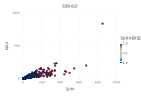

In [30]:
figures[1]

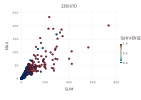

In [31]:
figures[2]

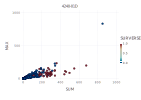

In [32]:
figures[3]

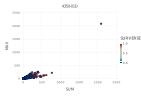

In [33]:
figures[4]

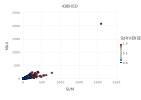

In [34]:
figures[5]

# 6. Conclusion

Il en ressort de ce projet, plusieurs solutions possibles. Dans notre cas, on a commencé par explorer les méthodes utilisées en cours et les appliquer à notre solution. Principalement, on a pu utiliser la régression logistique ainsi que la classification bayésienne naïve. Cette dernière a été plus performante en terme de précision. 

Les variables qu’on a pu prendre en considération lors de cette étude sont la moyenne des précipitations par jour, la plus grande valeur de précipitations par jour, la moyenne des précipitations de la veille et finalement le maximum de précipitations de la veille. En ce qui concerne les variables qui font références à “la veille”, elles ont été rejetées puisqu’elles baissent le score final. Nous avons remarqué que notre modèle n’a pas donné un très bon score. 

À ce sujet, on pense que l’utilisation d’un autre algorithme tel que SVM ou arbre de décision aurait donné un meilleur score mais ce dernier n’a pas pu être testé par manque de temps. Il serait également intéressant d’utiliser la validation croisée qui consiste à diviser nos données en “training data” , “test data” et “validation data”. Cette méthode nous aurait permis d’utiliser nos données pour les entraîner et les valider pour avoir une meilleur estimation avant de rendre sur kaggle puisqu’on a le droit a uniquement 2 soumissions par jour.
